In [ ]:
import re
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point, box
import pandas as pd
import calendar
from datetime import datetime, timedelta
import seaborn as sns


from tqdm import tqdm
from shapely import wkt
import rasterio
import rioxarray
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
from scipy.interpolate import griddata

from scipy.stats import linregress

# Load In Data

In [2]:
# Estimated Soil NOx Emission
# Unit: ng * N / (m^2 * s)
df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/Estimated_Soil_NOx_Emission_Year_2017.csv')
df = df[['lat', 'lon', 'time', 'Estimated_Soil_NOx_Emission']]

# MERRA-2 Data To Validation The Estimation
# This is a data set generated by Weng et al. (2020) based on MERRA-2 at 0.5° lat. × 0.625° lon.
# Unit: kgN/m2
MERRA = pd.read_csv('/global/scratch/users/liuwenjin021011/data/Validation-MERRA-2.csv')
MERRA = MERRA[['lon', 'lat', 'Area', 'EmisNO_Soil', 'updated time']]

In [3]:
MERRA


,lon,lat,Area,EmisNO_Soil,updated time
0,73.565217,18.0,3.670186e+09,1.876575e-05,2017-01
1,73.565217,18.0,3.670186e+09,2.732446e-05,2017-02
2,73.565217,18.0,3.670186e+09,2.886158e-05,2017-03
3,73.565217,18.0,3.670186e+09,4.648263e-05,2017-04
4,73.565217,18.0,3.670186e+09,1.215730e-04,2017-05
...,...,...,...,...,...
84343,134.921739,53.0,2.329673e+09,7.851023e-08,2017-08
84344,134.921739,53.0,2.329673e+09,3.518085e-08,2017-09
84345,134.921739,53.0,2.329673e+09,5.605743e-09,2017-10
84346,134.921739,53.0,2.329673e+09,1.702514e-10,2017-11


In [4]:
df

,lat,lon,time,Estimated_Soil_NOx_Emission
0,25.412697,97.328835,2017-12-24,1.202965
1,25.412697,97.422195,2017-12-24,1.183735
2,25.412697,97.515564,2017-12-24,1.159842
3,25.412697,99.009338,2017-12-24,0.571942
4,25.412697,99.102699,2017-12-24,0.580023
...,...,...,...,...
25265124,37.829597,118.988586,2017-12-31,0.142631
25265125,37.829597,119.081947,2017-12-31,0.162539
25265126,37.829597,119.175308,2017-12-31,0.173848
25265127,37.829597,119.268669,2017-12-31,0.178867


# Fig 3 - Validate Estimated Soil NOx with MERRA-2 Data

### Step 1: Convert Soil NOx Estimation to Unit kg*N/m^2 to Compare With MERRA

In [5]:
# Calculate Soil NOx Emission in kg*N/m^2 to compare with MERRA-2
def calculate_monthly_nox_emission(df):
    # Convert 'time' to datetime if it's not already
    df['time'] = pd.to_datetime(df['time'])
    
    # Convert emissions from ng * N / (m^2 * s) to kg * N / (m^2)
    seconds_per_day = 24 * 60 * 60
    df['Estimated_Soil_NOx_Emission_Kg_N'] = df['Estimated_Soil_NOx_Emission'] *seconds_per_day * 1e-12

    # Calculate Soil NOx emission in each month
    df['month'] = df['time'].dt.to_period('M')
    # Sum the emissions for each month for each lat-lon pair
    monthly_emission = df.groupby(['lat', 'lon', 'month'])['Estimated_Soil_NOx_Emission_Kg_N'].sum().reset_index()

    return monthly_emission


monthly_df = calculate_monthly_nox_emission(df)

### Step 2: Interpolate Soil NOx Emission to Merge With MERRA

In [6]:
def compare_grid_size(df_monthly, MERRA):
    # Get unique and sorted latitudes and longitudes for each DataFrame
    unique_lat_df = sorted(df_monthly['lat'].unique())
    unique_lon_df = sorted(df_monthly['lon'].unique())

    unique_lat_MERRA = sorted(MERRA['lat'].unique())
    unique_lon_MERRA = sorted(MERRA['lon'].unique())

    # Calculate the latitude and longitude step sizes
    lat_step_df = min(np.diff(unique_lat_df))
    lon_step_df = min(np.diff(unique_lon_df))

    lat_step_MERRA = min(np.diff(unique_lat_MERRA))
    lon_step_MERRA = min(np.diff(unique_lon_MERRA))

    # Determine the larger grid size based on the product of lat and lon steps
    df_monthly_grid_size = lat_step_df * lon_step_df
    MERRA_grid_size = lat_step_MERRA * lon_step_MERRA

    if df_monthly_grid_size > MERRA_grid_size:
        larger_df = 'df_monthly'
        lat_step = lat_step_df
        lon_step = lon_step_df
    else:
        larger_df = 'MERRA'
        lat_step = lat_step_MERRA
        lon_step = lon_step_MERRA

    print(f"The DataFrame with the larger grid size is {larger_df}")
    print(f"Latitude step: {lat_step}")
    print(f"Longitude step: {lon_step}")

compare_grid_size(monthly_df, MERRA)


The DataFrame with the larger grid size is MERRA
Latitude step: 0.49999999999998224
Longitude step: 0.6260869565216751


In [7]:
def interpolate_to_match_grid(df_monthly, MERRA):
    # Prepare the interpolation grid from MERRA dataset
    lon_grid = MERRA['lon'].unique()
    lat_grid = MERRA['lat'].unique()
    grid_lon, grid_lat = np.meshgrid(lon_grid, lat_grid)

    # Prepare an empty DataFrame to hold the interpolated values
    interpolated_data = pd.DataFrame()

    for month in df_monthly['month'].unique():
        # Filter data for the current month
        df_month = df_monthly[df_monthly['month'] == month]

        # Perform the interpolation for this month
        interpolated_values = griddata(
            points=(df_month['lon'], df_month['lat']),
            values=df_month['Estimated_Soil_NOx_Emission_Kg_N'],
            xi=(grid_lon, grid_lat),
            method='linear'
        )

        # Flatten the grid and create a DataFrame with the interpolated results
        interpolated_df = pd.DataFrame({
            'lon': grid_lon.ravel(),
            'lat': grid_lat.ravel(),
            'Estimated_Soil_NOx_Emission_Kg_N': interpolated_values.ravel(),
            'month': month
        })

        # Concatenate the results for this month to the main DataFrame
        interpolated_data = pd.concat([interpolated_data, interpolated_df])

    return interpolated_data.dropna()

interpolated_monthly_df = interpolate_to_match_grid(monthly_df, MERRA)


In [8]:
def join_and_rename(monthly_df, MERRA):
    # Ensure 'month' in monthly_df is in datetime format
    monthly_df['month'] = monthly_df['month'].astype(str)

    MERRA['updated time'] = pd.to_datetime(MERRA['updated time'], format='%Y-%m')
    MERRA['updated time'] = MERRA['updated time'].astype(str).str[0:7]

    # Join the dataframes on latitude, longitude, and the time columns
    merged_df = pd.merge(
        monthly_df,
        MERRA,
        left_on=['lat', 'lon', 'month'],
        right_on=['lat', 'lon', 'updated time'],
        how='inner'
    )

    # Rename columns
    merged_df.rename(
        columns={
            'Estimated_Soil_NOx_Emission_Kg_N': 'Estimated Soil NOx',
            'EmisNO_Soil': 'MERRA Soil Nox'
        },
        inplace=True
    )

    # Drop the temporary string date columns used for merging
    merged_df.drop(['updated time'], axis=1, inplace=True)

    return merged_df

# Example usage
merged_df = join_and_rename(interpolated_monthly_df, MERRA)

### Step 3: Plot and Compare The Soil NOx Emission Year-Round Avg [Estimated & MERRA]

/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


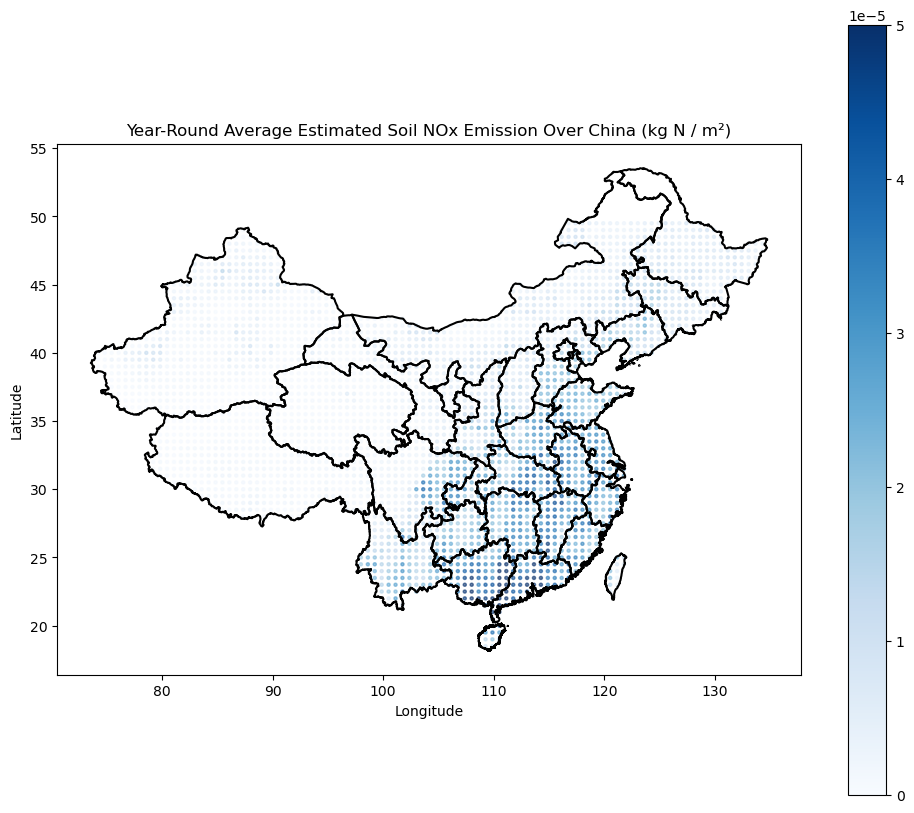

In [11]:
def plot_avg_soil_nox_over_china(df, shapefile_path):
    # Compute the year-round average Soil NOx emission
    avg_df = df.groupby(['lat', 'lon'])['Estimated_Soil_NOx_Emission_Kg_N'].mean().reset_index()
    avg_df.rename(columns={'Estimated_Soil_NOx_Emission_Kg_N': 'avg_Estimated_Soil_NOx_Emission_Kg_N'}, inplace=True)
    
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(avg_df, geometry=gpd.points_from_xy(avg_df.lon, avg_df.lat))
    gdf.set_crs(epsg=4326, inplace=True)

    # Load the shapefile for China
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Spatial join to filter only points within China
    gdf_within_china = gpd.sjoin(gdf, base_map, how="inner", op='intersects')
    if 'index_right' in gdf_within_china.columns:
        gdf_within_china.drop(columns=['index_right'], inplace=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black', alpha=0)
    gdf_within_china.plot(ax=ax, column='avg_Estimated_Soil_NOx_Emission_Kg_N', cmap='Blues', legend=True, markersize=5, alpha=0.6,  vmin=0, vmax=5 * 1e-5)
    base_map.boundary.plot(ax=ax, edgecolor='black')
    
    # ax.set_ylim(0, 10 * 1e-5)
    
    plt.title('Year-Round Average Estimated Soil NOx Emission Over China (kg N / m²)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Usage
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_avg_soil_nox_over_china(interpolated_monthly_df, shapefile_path)


/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


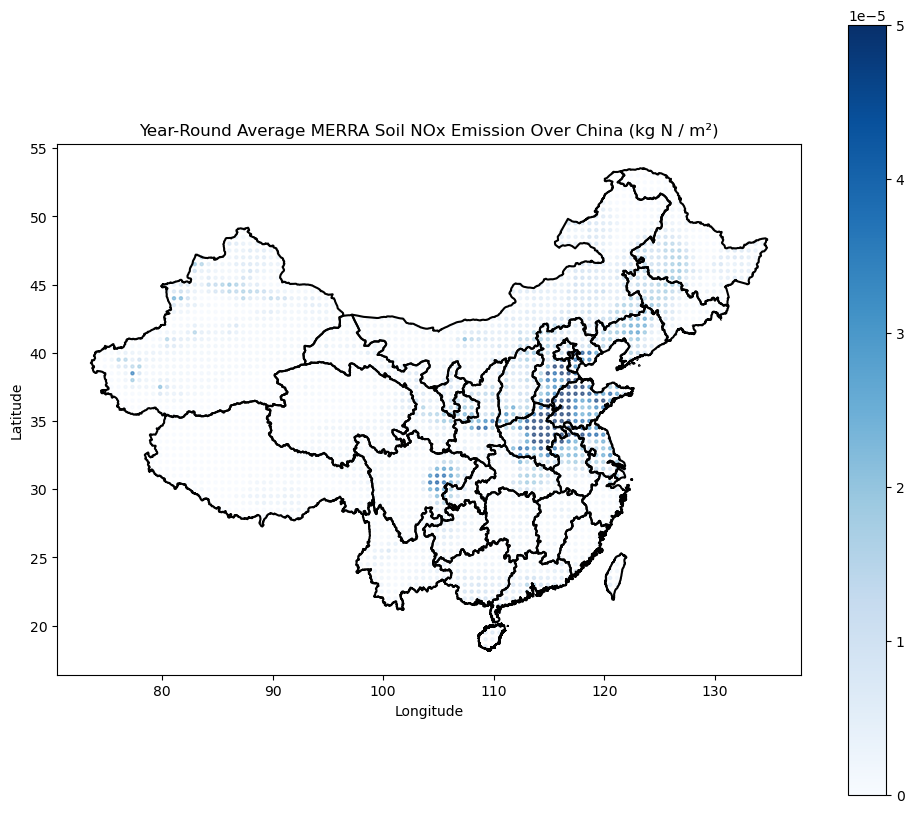

In [12]:
def plot_avg_merra_soil_nox_over_china(df, shapefile_path):
    # Compute the year-round average Soil NOx emission
    avg_df = df.groupby(['lat', 'lon'])['EmisNO_Soil'].mean().reset_index()
    avg_df.rename(columns={'EmisNO_Soil': 'avg_EmisNO_Soil'}, inplace=True)
    
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(avg_df, geometry=gpd.points_from_xy(avg_df.lon, avg_df.lat))
    gdf.set_crs(epsg=4326, inplace=True)

    # Load the shapefile for China
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Spatial join to filter only points within China
    gdf_within_china = gpd.sjoin(gdf, base_map, how="inner", op='intersects')
    if 'index_right' in gdf_within_china.columns:
        gdf_within_china.drop(columns=['index_right'], inplace=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black', alpha=0)
    gdf_within_china.plot(ax=ax, column='avg_EmisNO_Soil', cmap='Blues', legend=True, markersize=5, alpha=0.6,  vmin=0, vmax = 5 * 1e-5)
    base_map.boundary.plot(ax=ax, edgecolor='black')

    # Set the y-axis limit
    # ax.set_ylim(0, 10 * 1e-5)

    plt.title('Year-Round Average MERRA Soil NOx Emission Over China (kg N / m²)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Usage
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_avg_merra_soil_nox_over_china(MERRA, shapefile_path)


### Step 4: Correlation Between Estimated Soil NOx and MERRA Soil NOx Compare Based On Each Grid

In [13]:
avg_interpolated_monthly_df = interpolated_monthly_df.groupby(['lat', 'lon'])['Estimated_Soil_NOx_Emission_Kg_N'].mean().reset_index()
avg_interpolated_monthly_df.rename(columns={'Estimated_Soil_NOx_Emission_Kg_N': 'avg_Estimated_Soil_NOx_Emission_Kg_N'}, inplace=True)
    

In [14]:
avg_MERRA = MERRA.groupby(['lat', 'lon'])['EmisNO_Soil'].mean().reset_index()
avg_MERRA.rename(columns={'EmisNO_Soil': 'avg_EmisNO_Soil'}, inplace=True)

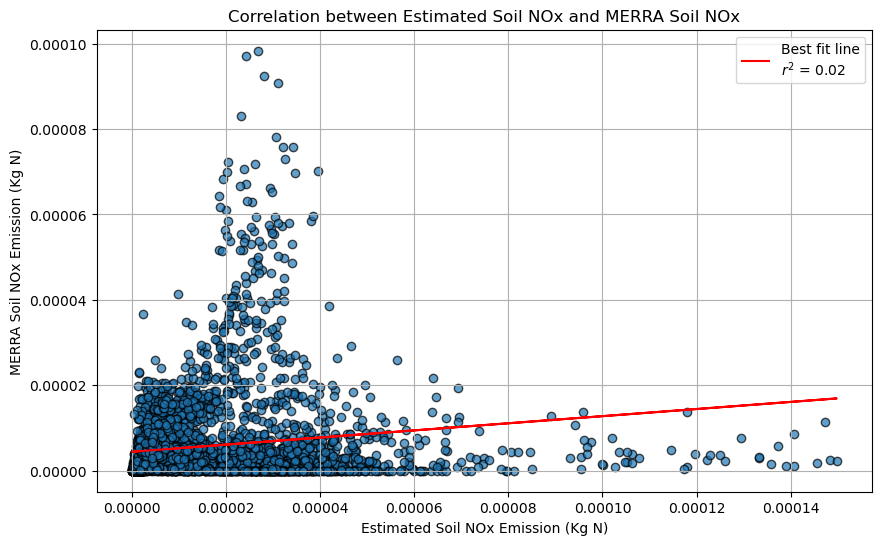

In [15]:
# Plot The Correlation Between Two DataSets Over Entire China

def plot_correlation(df1, df2, join_columns = ['lat', 'lon']):
    # Join the two dataframes on 'lat' and 'lon'
    merged_df = pd.merge(df1, df2, on=  join_columns)
    # merged_df = merged_df[merged_df['avg_EmisNO_Soil'] != 0]

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(merged_df['avg_Estimated_Soil_NOx_Emission_Kg_N'], merged_df['avg_EmisNO_Soil'])

    # Calculate best fit line
    line = slope * merged_df['avg_Estimated_Soil_NOx_Emission_Kg_N'] + intercept

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['avg_Estimated_Soil_NOx_Emission_Kg_N'], merged_df['avg_EmisNO_Soil'], edgecolor='k', alpha=0.7)
    plt.plot(merged_df['avg_Estimated_Soil_NOx_Emission_Kg_N'], line, 'r', label=f'Best fit line\n$r^2$ = {r_value**2:.2f}')
    plt.title('Correlation between Estimated Soil NOx and MERRA Soil NOx')
    plt.xlabel('Estimated Soil NOx Emission (Kg N)')
    plt.ylabel('MERRA Soil NOx Emission (Kg N)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return merged_df

# Example usage
merged_df = plot_correlation(avg_interpolated_monthly_df, avg_MERRA)


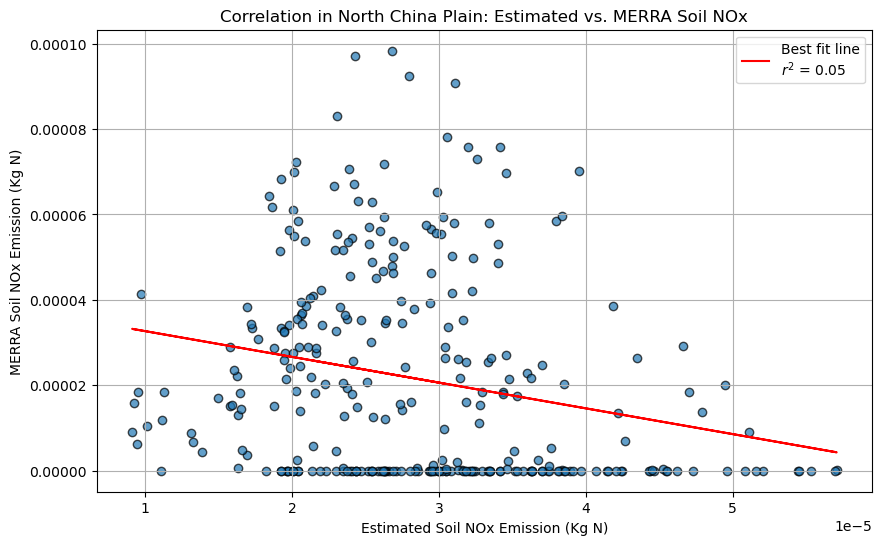

In [16]:
def plot_correlation_north_china_plain(df1, df2, lat_min=32, lat_max=40, lon_min=114, lon_max=125):
    # Filter the dataframes to include only the points within the North China Plain
    df1_filtered = df1[(df1['lat'] >= lat_min) & (df1['lat'] <= lat_max) & (df1['lon'] >= lon_min) & (df1['lon'] <= lon_max)]
    df2_filtered = df2[(df2['lat'] >= lat_min) & (df2['lat'] <= lat_max) & (df2['lon'] >= lon_min) & (df2['lon'] <= lon_max)]

    # Join the filtered dataframes on 'lat' and 'lon'
    merged_df = pd.merge(df1_filtered, df2_filtered, on=['lat', 'lon'])
    # merged_df = merged_df[merged_df['avg_EmisNO_Soil'] != 0]

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(merged_df['avg_Estimated_Soil_NOx_Emission_Kg_N'], merged_df['avg_EmisNO_Soil'])

    # Calculate best fit line
    line = slope * merged_df['avg_Estimated_Soil_NOx_Emission_Kg_N'] + intercept

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['avg_Estimated_Soil_NOx_Emission_Kg_N'], merged_df['avg_EmisNO_Soil'], edgecolor='k', alpha=0.7)
    plt.plot(merged_df['avg_Estimated_Soil_NOx_Emission_Kg_N'], line, 'r', label=f'Best fit line\n$r^2$ = {r_value**2:.2f}')
    plt.title('Correlation in North China Plain: Estimated vs. MERRA Soil NOx')
    plt.xlabel('Estimated Soil NOx Emission (Kg N)')
    plt.ylabel('MERRA Soil NOx Emission (Kg N)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return merged_df


merged_df =  plot_correlation_north_china_plain(avg_interpolated_monthly_df, avg_MERRA)


### Step 5: Correlation Between Estimated Soil NOx and MERRA Soil NOx Compare Based On Each Province

In [17]:
def calculate_nox_by_province(df, shapefile_path, time_col='time', nox_col='NOx'):
    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df['lon'], df['lat']),
        crs="EPSG:4326"  # WGS 84
    )

    # Read the shapefile
    provinces = gpd.read_file(shapefile_path)

    # Perform spatial join to assign each NOx emission point to a province
    merged_gdf = gpd.sjoin(gdf, provinces, how='inner', op='intersects')

    # Group by province and time to sum the NOx emissions
    nox_by_province_time = merged_gdf.groupby([time_col, 'ADM1_EN'])[nox_col].sum().reset_index()

    return nox_by_province_time

# Usage example
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
df_by_province_time = calculate_nox_by_province(monthly_df, shapefile_path, time_col='month', nox_col='Estimated_Soil_NOx_Emission_Kg_N')

MERRA_by_province_time = calculate_nox_by_province(MERRA, shapefile_path, time_col='updated time', nox_col='EmisNO_Soil')



/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_54538/3784373600.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  merged_gdf = gpd.sjoin(gdf, provinces, how='inner', op='intersects')
/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_54538/3784373600.py:13: UserWa

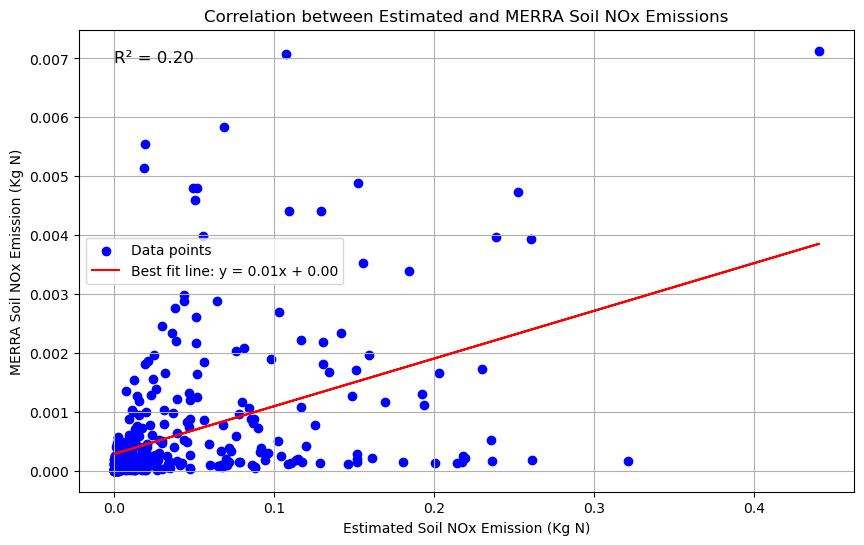

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_nox_correlation(df_by_province_time, MERRA_by_province_time):
    # Convert time columns to string format first to avoid PeriodDtype issue
    df_by_province_time['month'] = df_by_province_time['month'].astype(str)
    MERRA_by_province_time['updated time'] = MERRA_by_province_time['updated time'].astype(str)
    
    # Then convert to datetime
    df_by_province_time['month'] = pd.to_datetime(df_by_province_time['month'])
    MERRA_by_province_time['updated time'] = pd.to_datetime(MERRA_by_province_time['updated time'])

    # Merge the DataFrames on 'ADM1_EN' and time
    merged_df = pd.merge(
        df_by_province_time,
        MERRA_by_province_time,
        left_on=['month', 'ADM1_EN'],
        right_on=['updated time', 'ADM1_EN'],
        how='inner'
    )
    merged_df = merged_df[(merged_df['ADM1_EN'] != 'Heilongjiang Province') ]
    
    # Perform the linear regression and correlation
    x = merged_df['Estimated_Soil_NOx_Emission_Kg_N']
    y = merged_df['EmisNO_Soil']

    # Calculate the best fit line
    m, b = np.polyfit(x, y, 1)

    # Calculate the correlation coefficient
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy**2

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue', label='Data points')
    plt.plot(x, m*x + b, color='red', label=f'Best fit line: y = {m:.2f}x + {b:.2f}')
    
    plt.text(np.min(x), np.max(y), f'R² = {r_squared:.2f}', fontsize=12, verticalalignment='top')

    plt.title('Correlation between Estimated and MERRA Soil NOx Emissions')
    plt.xlabel('Estimated Soil NOx Emission (Kg N)')
    plt.ylabel('MERRA Soil NOx Emission (Kg N)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return merged_df

# Example usage, assuming you have the df_by_province_time and MERRA_by_province_time DataFrames already loaded
merged_df = plot_nox_correlation(df_by_province_time, MERRA_by_province_time)


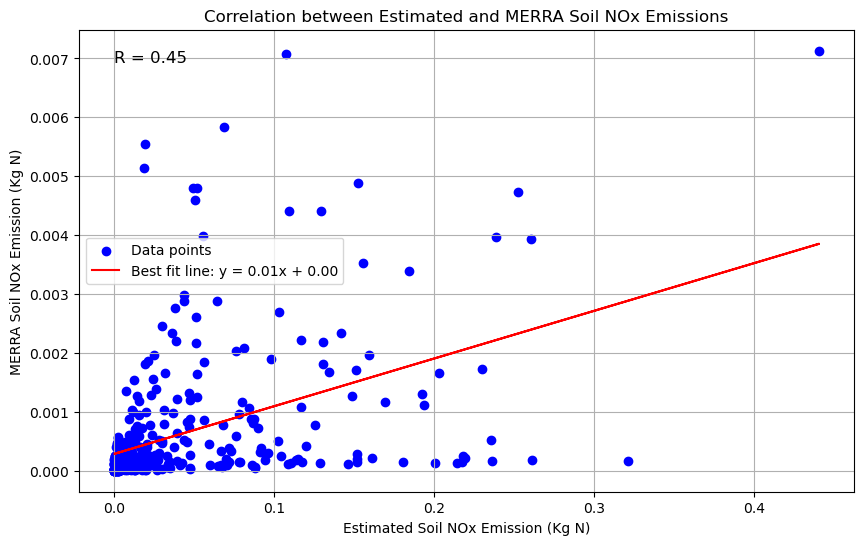

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_nox_correlation(df_by_province_time, MERRA_by_province_time):
    # Convert time columns to string format first to avoid PeriodDtype issue
    df_by_province_time['month'] = df_by_province_time['month'].astype(str)
    MERRA_by_province_time['updated time'] = MERRA_by_province_time['updated time'].astype(str)
    
    # Then convert to datetime
    df_by_province_time['month'] = pd.to_datetime(df_by_province_time['month'])
    MERRA_by_province_time['updated time'] = pd.to_datetime(MERRA_by_province_time['updated time'])

    # Merge the DataFrames on 'ADM1_EN' and time
    merged_df = pd.merge(
        df_by_province_time,
        MERRA_by_province_time,
        left_on=['month', 'ADM1_EN'],
        right_on=['updated time', 'ADM1_EN'],
        how='inner'
    )
    merged_df = merged_df[(merged_df['ADM1_EN'] != 'Heilongjiang Province') ]
    
    # Perform the linear regression and correlation
    x = merged_df['Estimated_Soil_NOx_Emission_Kg_N']
    y = merged_df['EmisNO_Soil']

    # Calculate the best fit line
    m, b = np.polyfit(x, y, 1)

    # Calculate the correlation coefficient
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy**2  # Calculate R-squared for other purposes if necessary

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue', label='Data points')
    plt.plot(x, m*x + b, color='red', label=f'Best fit line: y = {m:.2f}x + {b:.2f}')
    
    plt.text(np.min(x), np.max(y), f'R = {correlation_xy:.2f}', fontsize=12, verticalalignment='top')  # Changed from R² to R

    plt.title('Correlation between Estimated and MERRA Soil NOx Emissions')
    plt.xlabel('Estimated Soil NOx Emission (Kg N)')
    plt.ylabel('MERRA Soil NOx Emission (Kg N)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return merged_df

# Example usage, assuming you have the df_by_province_time and MERRA_by_province_time DataFrames already loaded
merged_df = plot_nox_correlation(df_by_province_time, MERRA_by_province_time)


# Fig 6 - Contribution of Soil NOx to Total NOx Emissions

### Step 1 - PreProcess Estimated Soil NOx df To Add Province Info

### Step 2 - Confirm The Reference DataSet CAS_df Is Resonable

In [20]:
# ABaCAS NOx
file_path = '/global/scratch/users/liuwenjin021011/data/ABaCAS-EI v2.0 dataset.xlsx'
CAS_df = pd.read_excel(file_path, sheet_name='NOx')

# Estimated NOx
Estimate_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/Estimated_Soil_NOx_Emission_By_Province_Year_2017.csv')


In [21]:
# Unit: kt = Gg = 1e6 kg
# According to the census of “the Second National Pollution Source Census Bulletin of China” 
# for industrial, agricultural, domestic, centralized pollution control facilities, and mobile sources 
# emitting pollutants in the territory, the national NOx emissions in 2017 were
# 17,852 Gg N/yr,


CAS_df = CAS_df[CAS_df['Year'] == 2017]
print('Total NOx Emission In Year 2017', sum(CAS_df['China']), 'Gg N')
# Comaprable to 17,852 Gg N/yr!


Total NOx Emission In Year 2017 18467.24576609594 Gg N


In [22]:
def aggregate_province_nox(df):
    # Mapping short province names to their full administrative names
    province_map = {
        'Beijing': 'Beijing Municipality',
        'Tianjin': 'Tianjin Municipality',
        'Hebei': 'Hebei Province',
        'Shanxi': 'Shanxi Province',
        'Inner Mongolia': 'Inner Mongolia Autonomous Region',
        'Liaoning': 'Liaoning Province',
        'Jilin': 'Jilin Province',
        'Heilongjiang': 'Heilongjiang Province',
        'Shanghai': 'Shanghai Municipality',
        'Jiangsu': 'Jiangsu Province',
        'Zhejiang': 'Zhejiang Province',
        'Anhui': 'Anhui Province',
        'Fujian': 'Fujian Province',
        'Jiangxi': 'Jiangxi Province',
        'Shandong': 'Shandong Province',
        'Henan': 'Henan Province',
        'Hubei': 'Hubei Province',
        'Hunan': 'Hunan Province',
        'Guangdong': 'Guangdong Province',
        'Guangxi': 'Guangxi Zhuang Autonomous Region',
        'Hainan': 'Hainan Province',
        'Chongqing': 'Chongqing Municipality',
        'Sichuan': 'Sichuan Province',
        'Guizhou': 'Guizhou Province',
        'Yunnan': 'Yunnan Province',
        'Tibet': 'Tibet Autonomous Region',
        'Shaanxi': 'Shaanxi Province',
        'Gansu': 'Gansu province',
        'Qinghai': 'Qinghai Province',
        'Ningxia': 'Ningxia Hui Autonomous Region',
        'Xinjiang': 'Xinjiang Uygur Autonomous Region'
        # Note: Hong Kong, Macau, and Taiwan are not typically included in these types of mainland datasets
    }

    # Melt the dataframe to have provinces and their NOx emissions in rows
    melted_df = df.melt(id_vars=['Year', 'Sector '], var_name='Province', value_name='Total NOx_N')
    melted_df['Province'] = melted_df['Province'].replace(province_map)

   
    aggregated_df = melted_df.groupby(['Year', 'Province'])['Total NOx_N'].sum().reset_index()
    # Convert Unit kt to Kg
    aggregated_df['Total NOx_N'] = aggregated_df['Total NOx_N'] * 1e6

    return aggregated_df

CAS_df = aggregate_province_nox(CAS_df)
CAS_df = CAS_df[CAS_df['Province'] != 'China']
CAS_df.head(2)



,Year,Province,Total NOx_N
0,2017,Anhui Province,1.233703e+09
1,2017,Beijing Municipality,1.073482e+08


### Step 3 - Calculate NOx Emission Rate in Unit Kg/km^2

In [23]:
def calculate_nox_emission_rate(df, shapefile_path, province_column='Province', nox_column='NOx emission', rate_column = 'NOx_emission_rate'):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Ensure the GeoDataFrame has the correct CRS before calculating area
    # Assuming the shapefile is in the EPSG:4326 CRS (latitude and longitude)
    gdf = gdf.set_crs(epsg=4326)

    # Calculate the area of each province in square kilometers
    # Transform the CRS to EPSG:3395 (a projection suitable for area calculations) before calculating area
    gdf['Area_km2'] = gdf.to_crs(epsg=3395).area / 1e6  # convert from m^2 to km^2
    
    # Merge the NOx emission data with the shapefile data based on the province
    merged_df = pd.merge(df, gdf, left_on=province_column, right_on='ADM1_EN', how='inner')
    
    # Calculate the NOx emission rate
    merged_df[rate_column] = merged_df[nox_column] / merged_df['Area_km2']
    
    return merged_df[[province_column, nox_column, 'Area_km2', rate_column]]



shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
CAS_rate_df = calculate_nox_emission_rate(CAS_df, 
                shapefile_path, province_column='Province', nox_column='Total NOx_N', rate_column = 'Total NOx Rate')

Estimate_rate_df = calculate_nox_emission_rate(Estimate_df.groupby(['year', 'ADM1_EN']).sum().reset_index(), 
                shapefile_path, province_column='ADM1_EN', nox_column='NOx_kg_N', rate_column = 'Soil NOx Rate')


In [24]:
CAS_rate_df.columns

Index(['Province', 'Total NOx_N', 'Area_km2', 'Total NOx Rate'], dtype='object')

In [25]:
Estimate_rate_df.columns

Index(['ADM1_EN', 'NOx_kg_N', 'Area_km2', 'Soil NOx Rate'], dtype='object')

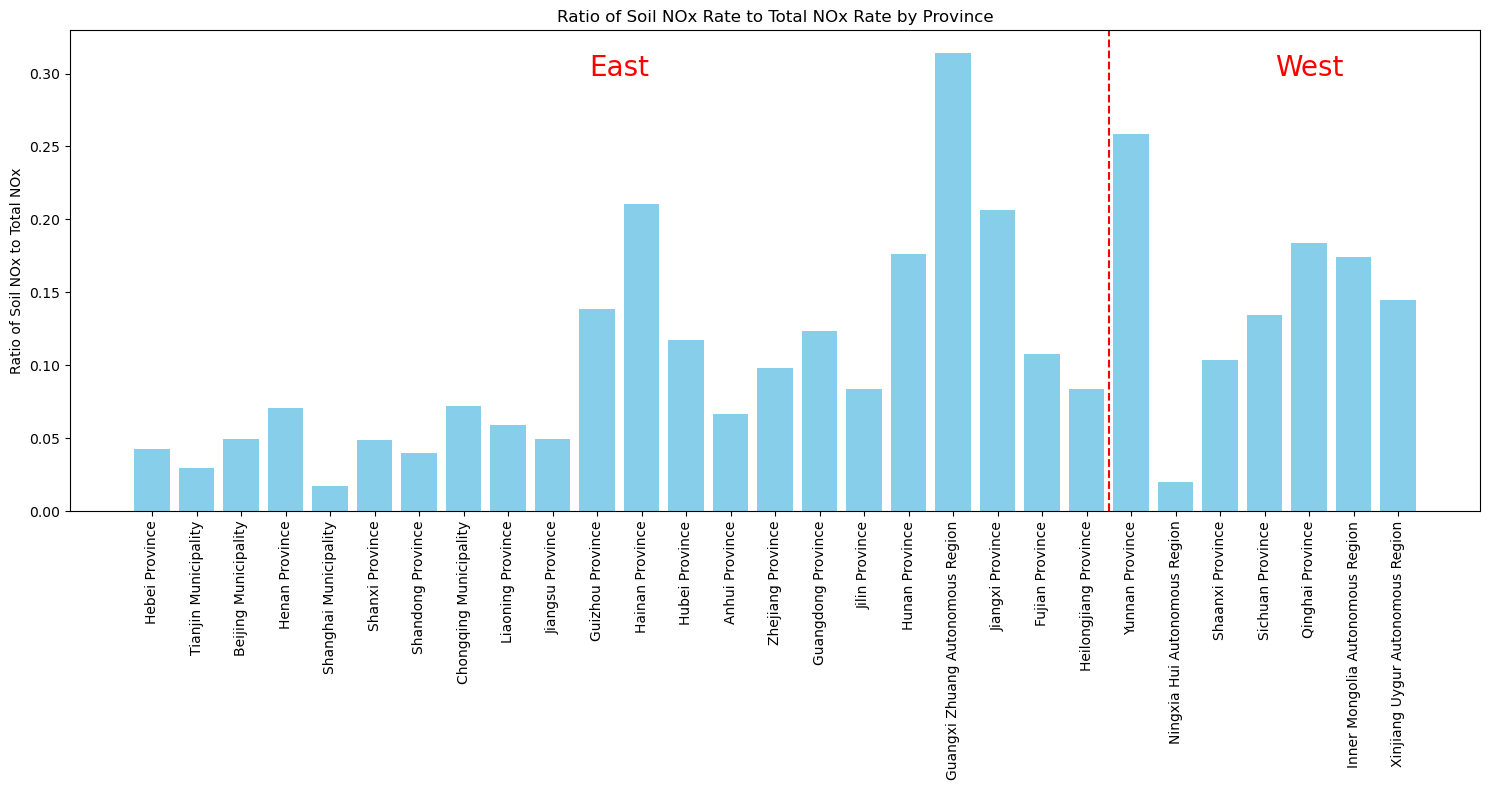

In [26]:

def plot_nox_rate_comparison(CAS_rate_df, Estimate_rate_df):
    # Merge the dataframes on province names
    merged_df = pd.merge(
        Estimate_rate_df, 
        CAS_rate_df, 
        left_on='ADM1_EN', 
        right_on='Province', 
        how='inner'
    )

    # Calculate the ratio of Soil NOx rate to Total NOx rate
    merged_df['NOx_Rate_Ratio'] = merged_df['Soil NOx Rate'] / merged_df['Total NOx Rate']

    # Define the order of provinces for the x-axis
    province_order = [
        'Hebei Province', 'Tianjin Municipality', 'Beijing Municipality', 'Henan Province', 
        'Shanghai Municipality', 'Shanxi Province', 'Shandong Province', 'Chongqing Municipality', 
        'Liaoning Province', 'Jiangsu Province', 'Guizhou Province', 'Hainan Province', 
        'Hubei Province', 'Anhui Province', 'Zhejiang Province', 'Guangdong Province', 
        'Jilin Province', 'Hunan Province', 'Guangxi Zhuang Autonomous Region', 'Jiangxi Province', 
        'Fujian Province', 'Heilongjiang Province', 'Yunnan Province', 'Ningxia Hui Autonomous Region', 
        'Shaanxi Province', 'Sichuan Province', 'Gansu Province', 'Qinghai Province', 
        'Tibet Autonomous Region', 'Inner Mongolia Autonomous Region', 'Xinjiang Uygur Autonomous Region'
    ]

    # Filter and order the dataframe by the specified province order
    merged_df = merged_df[merged_df['Province'].isin(province_order)]
    merged_df['Province'] = pd.Categorical(merged_df['Province'], categories=province_order, ordered=True)
    merged_df = merged_df.sort_values('Province')

    # Plotting
    plt.figure(figsize=(15, 8))
    bars = plt.bar(merged_df['Province'], merged_df['NOx_Rate_Ratio'], color='skyblue')

    # Add a vertical line between Heilongjiang and Yunnan
    heilongjiang_index = province_order.index('Heilongjiang Province')
    plt.axvline(x=heilongjiang_index + 0.5, color='red', linestyle='--')

    # Add text for East and West with larger font size
    plt.text(heilongjiang_index / 2, max(merged_df['NOx_Rate_Ratio']) * 0.95, 'East', ha='center', color='red', fontsize=20)
    plt.text((heilongjiang_index + len(province_order)) / 2, max(merged_df['NOx_Rate_Ratio']) * 0.95, 'West', ha='center', color='red', fontsize=20)

    plt.xticks(rotation=90)
    plt.ylabel('Ratio of Soil NOx to Total NOx')
    plt.title('Ratio of Soil NOx Rate to Total NOx Rate by Province')
    plt.tight_layout()
    plt.show()

# Example usage
plot_nox_rate_comparison(CAS_rate_df, Estimate_rate_df)


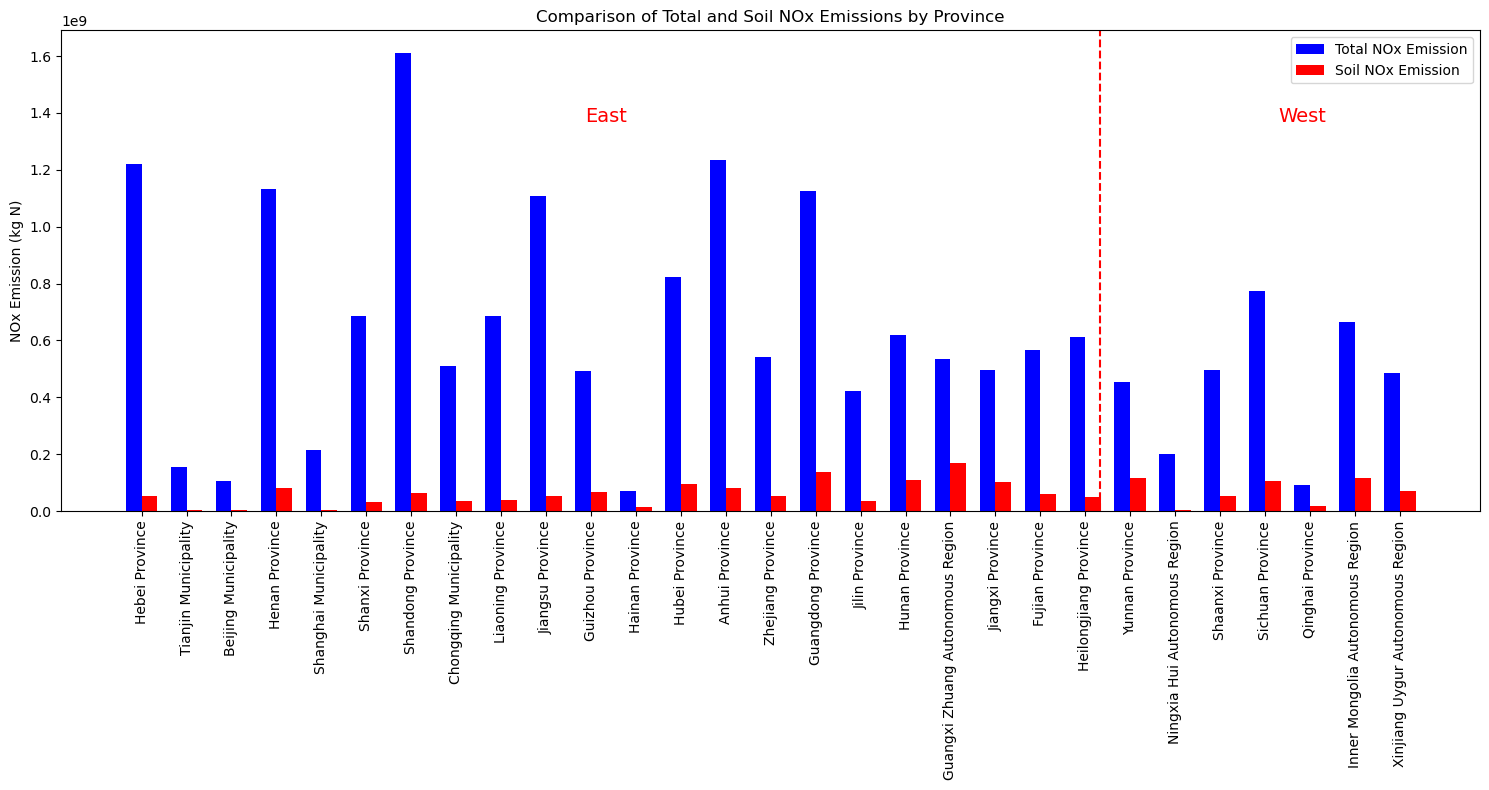

In [27]:
def plot_nox_emission_comparison(CAS_rate_df, Estimate_rate_df):
    # Merge the dataframes on province names
    merged_df = pd.merge(
        Estimate_rate_df, 
        CAS_rate_df, 
        left_on='ADM1_EN', 
        right_on='Province', 
        how='inner'
    )

    # Define the order of provinces for the x-axis
    province_order = [
        'Hebei Province', 'Tianjin Municipality', 'Beijing Municipality', 'Henan Province', 
        'Shanghai Municipality', 'Shanxi Province', 'Shandong Province', 'Chongqing Municipality', 
        'Liaoning Province', 'Jiangsu Province', 'Guizhou Province', 'Hainan Province', 
        'Hubei Province', 'Anhui Province', 'Zhejiang Province', 'Guangdong Province', 
        'Jilin Province', 'Hunan Province', 'Guangxi Zhuang Autonomous Region', 'Jiangxi Province', 
        'Fujian Province', 'Heilongjiang Province', 'Yunnan Province', 'Ningxia Hui Autonomous Region', 
        'Shaanxi Province', 'Sichuan Province', 'Gansu Province', 'Qinghai Province', 
        'Tibet Autonomous Region', 'Inner Mongolia Autonomous Region', 'Xinjiang Uygur Autonomous Region'
    ]

    # Filter and order the dataframe by the specified province order
    merged_df = merged_df[merged_df['Province'].isin(province_order)]
    merged_df['Province'] = pd.Categorical(merged_df['Province'], categories=province_order, ordered=True)
    merged_df = merged_df.sort_values('Province')

    # Plotting
    plt.figure(figsize=(15, 8))

    # Width of the bars
    bar_width = 0.35

    # Positions of the bars
    r1 = range(len(merged_df['Province']))
    r2 = [x + bar_width for x in r1]

    # Create the bars
    plt.bar(r1, merged_df['Total NOx_N'], width=bar_width, label='Total NOx Emission', color='b')
    plt.bar(r2, merged_df['NOx_kg_N'], width=bar_width, label='Soil NOx Emission', color='r')

    # Add a vertical line between Heilongjiang and Yunnan
    heilongjiang_index = province_order.index('Heilongjiang Province')
    plt.axvline(x=heilongjiang_index + 0.5, color='red', linestyle='--')

    # Add text for East and West with larger font size
    plt.text(heilongjiang_index / 2, max(merged_df['Total NOx_N']) * 0.85, 'East', ha='center', color='red', fontsize=14)
    plt.text((heilongjiang_index + len(province_order)) / 2, max(merged_df['Total NOx_N']) * 0.85, 'West', ha='center', color='red', fontsize=14)

    # Add xticks, labels, and title
    plt.xticks([r + bar_width/2 for r in range(len(r1))], merged_df['Province'], rotation=90)
    plt.ylabel('NOx Emission (kg N)')
    plt.title('Comparison of Total and Soil NOx Emissions by Province')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return merged_df
# Example usage
merged_df = plot_nox_emission_comparison(CAS_rate_df, Estimate_rate_df)


In [30]:
merged_df.columns

Index(['ADM1_EN', 'NOx_kg_N', 'Area_km2_x', 'Soil NOx Rate', 'Province',
       'Total NOx_N', 'Area_km2_y', 'Total NOx Rate'],
      dtype='object')

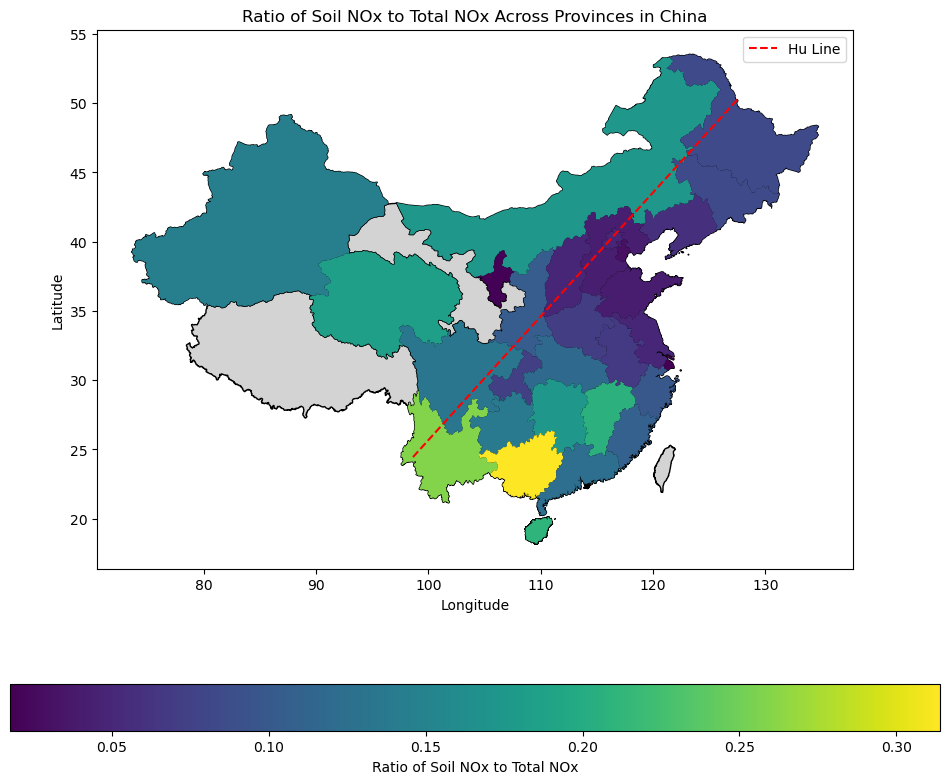

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

def plot_soil_nox_to_total_nox_ratio(merged_df, shapefile_path):
    # Calculate the ratio of Soil NOx to Total NOx
    merged_df['Soil_to_Total_NOx_Ratio'] = merged_df['Soil NOx Rate'] / merged_df['Total NOx Rate']

    # Load the shapefile for China and ensure CRS compatibility
    china_map = gpd.read_file(shapefile_path)
    china_map.set_crs(epsg=4326, inplace=True)  # Assuming the CRS is WGS 84, update if different

    # Merge DataFrame with the shapefile based on the province names
    # Ensure province names in both DataFrame and shapefile match and are in the same format
    merged_gdf = china_map.merge(merged_df, left_on='ADM1_EN', right_on='Province', how='inner')

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 10))
    china_map.plot(ax=ax, color='lightgrey', edgecolor='black')  # Base map with light grey as the background
    merged_gdf.plot(ax=ax, column='Soil_to_Total_NOx_Ratio', cmap='viridis', legend=True,
                    legend_kwds={'label': "Ratio of Soil NOx to Total NOx", 'orientation': "horizontal"})
    
    # Coordinates for Heihe and Tengchong to draw the Hu Line
    heihe_coords = (50.2443, 127.4889)  # Heihe coordinates (lat, lon)
    tengchong_coords = (24.3405, 98.4943)  # Tengchong coordinates (lat, lon)

    # Draw the Hu Line
    hu_line = LineString([heihe_coords[::-1], tengchong_coords[::-1]])  # Reverse coordinates for (lon, lat)
    ax.plot(*hu_line.xy, color='red', linestyle='--', label='Hu Line')
   # Coordinates for Heihe and Tengchong to draw the Hu Line
    heihe_coords = (50.2443, 127.4889)  # Heihe coordinates (lat, lon)
    tengchong_coords = (24.3405, 98.4943)  # Tengchong coordinates (lat, lon)


    
    plt.title('Ratio of Soil NOx to Total NOx Across Provinces in China')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Example usage
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_soil_nox_to_total_nox_ratio(merged_df, shapefile_path)


In [32]:
merged_df

,ADM1_EN,NOx_kg_N,Area_km2_x,Soil NOx Rate,Province,Total NOx_N,Area_km2_y,Total NOx Rate,Soil_to_Total_NOx_Ratio
9,Hebei Province,5.215208e+07,3.130292e+05,166.604543,Hebei Province,1.221273e+09,3.130292e+05,3901.465461,0.042703
26,Tianjin Municipality,4.491084e+06,1.934406e+04,232.168671,Tianjin Municipality,1.539128e+08,1.934406e+04,7956.591079,0.029179
1,Beijing Municipality,5.325539e+06,2.786336e+04,191.130507,Beijing Municipality,1.073482e+08,2.786336e+04,3852.664422,0.049610
11,Henan Province,8.011405e+07,2.386748e+05,335.661976,Henan Province,1.133516e+09,2.386748e+05,4749.206898,0.070677
23,Shanghai Municipality,3.725030e+06,8.075082e+03,461.299289,Shanghai Municipality,2.135005e+08,8.075082e+03,26439.419263,0.017447
24,Shanxi Province,3.342829e+07,2.495855e+05,133.935226,Shanxi Province,6.849633e+08,2.495855e+05,2744.403411,0.048803
22,Shandong Province,6.352506e+07,2.353155e+05,269.956994,Shandong Province,1.610110e+09,2.353155e+05,6842.346769,0.039454
2,Chongqing Municipality,3.677753e+07,1.081615e+05,340.024092,Chongqing Municipality,5.109365e+08,1.081615e+05,4723.827959,0.071981
18,Liaoning Province,4.032794e+07,2.540262e+05,158.755055,Liaoning Province,6.845551e+08,2.540262e+05,2694.821092,0.058911
15,Jiangsu Province,5.456925e+07,1.417394e+05,384.997049,Jiangsu Province,1.108727e+09,1.417394e+05,7822.293085,0.049218


# Fig 7 - Spacial Trend Of Soil NOx Emissions Divided By 'Hu Line'

In [2]:
df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/Estimated_Soil_NOx_Emission_Year_2017.csv')

(153210, 3)


/tmp/ipykernel_6356/3489391602.py:59: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_Estimated_Soil_NOx_Emission_within_shape(df, shapefile_path)


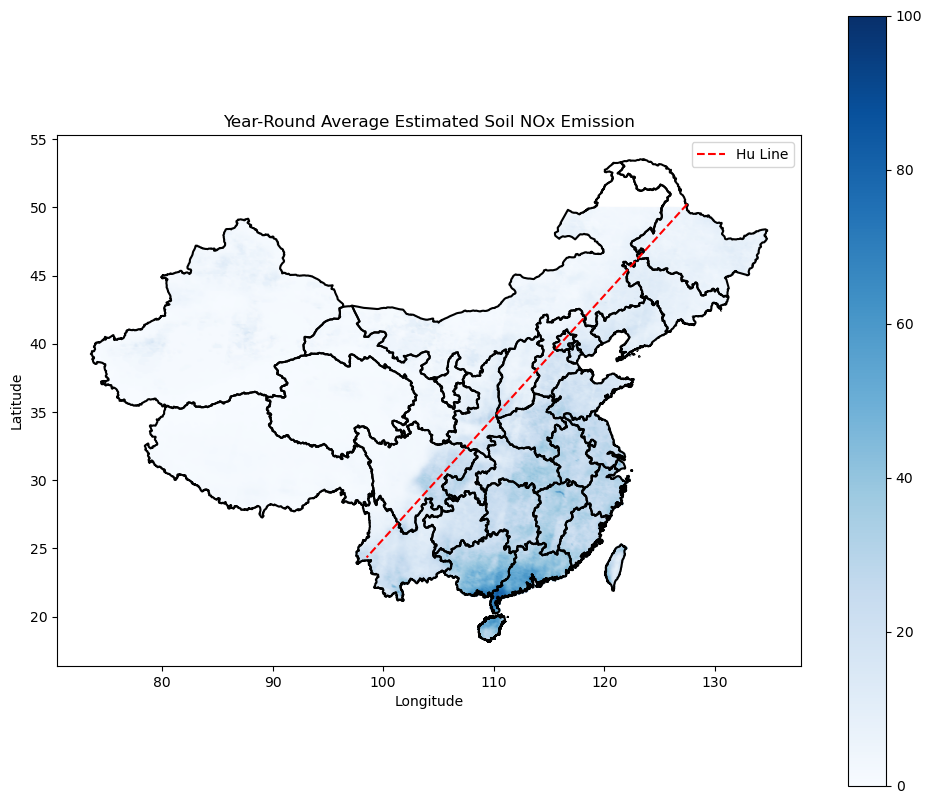

In [3]:
def filter_points_within_shape(df, shapefile_path, column='Estimated_Soil_NOx_Emission'):
    # Compute the average of the column of interest
    avg_df = df.groupby(['lat', 'lon'])[column].mean().reset_index()
    avg_df.rename(columns={column: 'avg_Estimated_Soil_NOx_Emission'}, inplace=True)
    print(avg_df.shape)

    # Convert df to a GeoDataFrame
    gdf = gpd.GeoDataFrame(avg_df, geometry=gpd.points_from_xy(avg_df.lon, avg_df.lat))

    # Set the coordinate reference system (CRS)
    gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84, adjust as necessary

    # Load the shapefile
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Perform spatial join to keep only points within the shapefile boundaries
    gdf_within_shape = gpd.sjoin(gdf, base_map, how="inner", op='intersects')

    # Drop the 'index_right' column if exists
    if 'index_right' in gdf_within_shape.columns:
        gdf_within_shape.drop(columns=['index_right'], inplace=True)

    return gdf_within_shape

from shapely.geometry import LineString

def plot_Estimated_Soil_NOx_Emission_within_shape(df, shapefile_path, title='Year-Round Average Estimated Soil NOx Emission', vmin=0, vmax=100):
    # Filter points to keep only those within the shapefile
    filtered_df = filter_points_within_shape(df, shapefile_path, 'Estimated_Soil_NOx_Emission')

    # Load the shapefile
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black', alpha=0)  # Plot the base map first with no fill color
    filtered_df.plot(ax=ax, column='avg_Estimated_Soil_NOx_Emission', cmap='Blues', legend=True, markersize=2, alpha=0.5, vmin=vmin, vmax=vmax)  # Then plot the data points
    base_map.boundary.plot(ax=ax, edgecolor='black')  # Plot the boundaries on top

    # Coordinates for Heihe and Tengchong to draw the Hu Line
    heihe_coords = (50.2443, 127.4889)  # Heihe coordinates (lat, lon)
    tengchong_coords = (24.3405, 98.4943)  # Tengchong coordinates (lat, lon)

    # Draw the Hu Line
    hu_line = LineString([heihe_coords[::-1], tengchong_coords[::-1]])  # Reverse coordinates for (lon, lat)
    ax.plot(*hu_line.xy, color='red', linestyle='--', label='Hu Line')

    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()

    plt.show()

# Usage
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_Estimated_Soil_NOx_Emission_within_shape(df, shapefile_path)



# Fig 9 - Temporal Trend of Soil NOx Emissions

In [80]:
df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/Estimated_Soil_NOx_Emission_By_Province_Year_2017.csv')


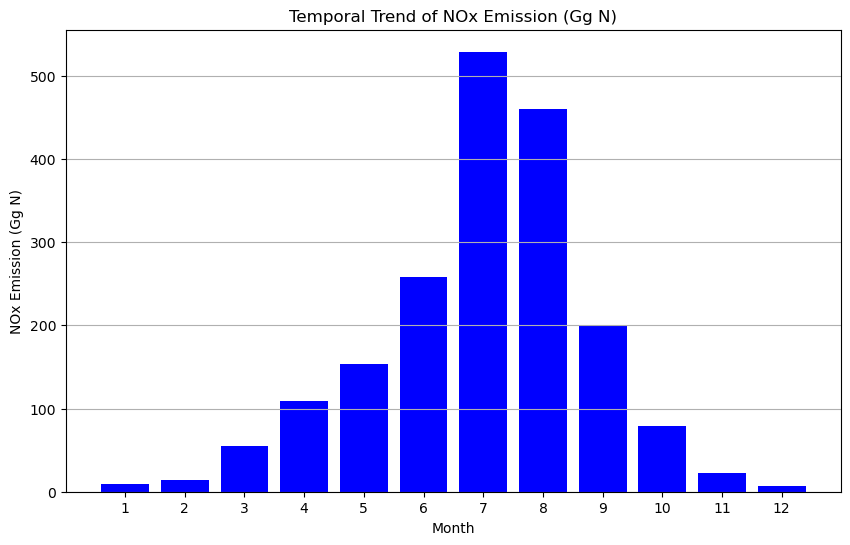

In [88]:
def plot_temporal_trend_NOx_bar(df):
    # Ensure 'month' is of type int to handle sorting and plotting correctly
    df['month'] = df['month'].astype(int)
    
    # Convert kg N to Gg N (1 Gg = 1e6 kg)
    df['NOx_Gg_N'] = df['NOx_kg_N'] / 1e6

    # Aggregate NOx emissions by month
    monthly_NOx = df.groupby('month')['NOx_Gg_N'].sum().reset_index()

    # Plot the temporal trend as a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_NOx['month'], monthly_NOx['NOx_Gg_N'], color='blue')
    
    plt.title('Temporal Trend of NOx Emission (Gg N)')
    plt.xlabel('Month')
    plt.ylabel('NOx Emission (Gg N)')
    plt.xticks(monthly_NOx['month'], labels=[str(m) for m in range(1, 13)])  # Ensure month labels are correct
    plt.grid(axis='y')
    plt.show()

# Example usage
plot_temporal_trend_NOx_bar(df)
